In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import itertools
from tabulate import tabulate
import io, base64
from PIL import Image

from action_utils import *

# Data

In [4]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [4]:
from multiprocessing import Pool
import time

main_df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
N = 100000
np.random.seed(42)
steps = 1

def generate_train_data(smile):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    index = []
    
    # Get sequences
    try:
        for i in range(steps):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product)]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    
    # Fix index
    df.index = index
    
    # Make combinations for multi-step possibilities of source-->target
    for i in range(df.shape[0]-1, 0, -1):
        new_df = df.iloc[:i].copy()
        new_df["product"] = df.iloc[i]["product"]
        df = pd.concat([df, new_df])
        
    return df

df_list = []
final_shape = 0
# Create dataset for 5 step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(1000,))

        for new_df in p.imap_unordered(generate_train_data, smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

(3976954, 10)
(100000, 10)


In [13]:
main_df = main_df.iloc[-10000:]
main_df.shape

(10000, 10)

# Load models

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [49]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out

class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = torch.load("datasets/my_uspto/supervised_zinc_gin/mse_model.pth")
    
    def forward(self, x1, x2):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2], axis=1)
        out = self.DENSE(out)
        return out

model_basic = PolicyNetwork().to(device)
model_final = torch.load("models/supervised/emb_model_update=1||-ve_method=all||dist_metric=euclidean||topk=5/model.pth").to(device)
model_basic.eval(), model_final.eval()
pass

In [50]:
emb_model_basic = model_basic.GIN
emb_model_final = model_final.GIN

# Get action_embeddings 

In [51]:
from torchdrug import data
from torchdrug import utils

def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def get_mol_embedding(model, smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    else:
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    mol = mol.to(device)
    emb = model(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach()

def get_action_embedding(model, action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
    embedding = torch.concatenate([
                        get_mol_embedding(model, rsig), 
                        get_mol_embedding(model, psig)
                    ], axis=1)
    return embedding

def get_ranking(pred, emb_for_comparison, correct_index, distance="euclidean", k=None):
    '''
    Get the rank of the prediction from the applicable actions.
    Returns (rank, [list_of_indices before <rank>])
    '''
    if distance == "euclidean":
        dist = ((emb_for_comparison-pred)**2).sum(axis=1)
    elif distance == "cosine":
        dist = 1 - (emb_for_comparison.dot(pred))/(torch.linalg.norm(emb_for_comparison, axis=1)*torch.linalg.norm(pred))

    maxy = max(dist)

    list_of_indices = []
    for attempt in range(dist.shape[0]):
        miny = dist.argmin()
#         print(miny, correct_index, dist[correct_index], min(dist), maxy)
        if dist[miny] == dist[correct_index]:
#             print(i, attempt)
            break
        else:
            list_of_indices.append(miny)
            if k is not None and len(list_of_indices) == k:
                return list_of_indices
            dist[miny] = 100000
    
    # When the rank(correct_index) < k, then returns <rank, list>. So this extra condition - add some indices after rank(correct_index) to the list
    if k is not None:
        dist[miny] = 100000
        for attempt in range(min(k, emb_for_comparison.shape[0]-1) - len(list_of_indices)):
            miny = dist.argmin()
            list_of_indices.append(miny)
            dist[miny] = 100000
        return list_of_indices
    return attempt, list_of_indices

In [52]:
batch_size = 128
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["reactant_works"] & action_dataset["reactant_tested"] & action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

def get_action_dataset_embeddings(model):
    action_embeddings = []
    for i in tqdm.tqdm(range(0, action_dataset.shape[0], batch_size)):
        action_embeddings.append(get_action_embedding(model, action_dataset.iloc[i:i+batch_size]))
    action_embeddings = torch.concatenate(action_embeddings)
    return action_embeddings

action_embeddings_basic = get_action_dataset_embeddings(emb_model_basic)
print(action_embeddings_basic.shape)
action_embeddings_final = get_action_dataset_embeddings(emb_model_final)
print(action_embeddings_final.shape)

(88995, 8)


100%|██████████████████████████████████████████████████████████████| 696/696 [09:35<00:00,  1.21it/s]


torch.Size([88995, 256])


100%|██████████████████████████████████████████████████████████████| 696/696 [09:32<00:00,  1.22it/s]

torch.Size([88995, 256])


# Analysis

In [53]:
# store correct index and action_embedding_indices to save compute later
# I'm storing as lists, so doing numpy operations for the elements
correct_indices = []
action_embedding_indices = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    row = main_df.iloc[i]
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    
    indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
    action_embedding_indices.append(indices_used_for_data)

    applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
    correct_indices.append(indices_used_for_data[(applicable_actions_df.index == row.name).argmax()])

100%|██████████████████████████████████████████████████████████| 10000/10000 [12:54<00:00, 12.91it/s]


#### Rank distribution for end-to-end model 

In [54]:
# Model inputs
reactant_mols = data.Molecule.pack(list(map(molecule_from_smile, main_df["reactant"]))).to(device)

product_mols = data.Molecule.pack(list(map(molecule_from_smile, main_df["product"]))).to(device)

# Prediction
# bs = 5000
pred = model_final(reactant_mols, product_mols).detach()
# pred = model(reactant_mols[:bs], product_mols[:bs]).detach()
# for i in range(bs, reactant_mols.batch_size, bs):
#         pred = torch.concatenate([pred, model(reactant_mols[i:i+bs], product_mols[i:i+bs]).detach()], axis=0)
#         torch.cuda.empty_cache() # Get rid of the pytorch graph (takes goes OOM otherwise)
print(pred.shape)

torch.Size([10000, 256])


In [55]:
rank_list = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_index = action_embeddings_final[action_embedding_indices[i]], correct_indices[i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
    rank_list.append(rank)

100%|██████████████████████████████████████████████████████████| 10000/10000 [14:58<00:00, 11.13it/s]


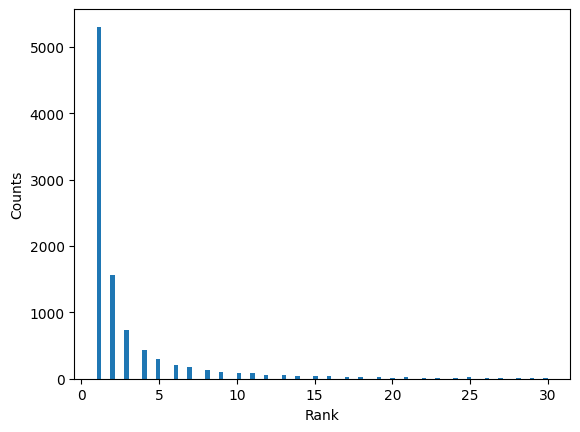

In [56]:
%matplotlib inline
arr = np.sort(rank_list)

plt.hist(arr[:int(arr.shape[0]*0.96)]+1, bins=100)
plt.xlabel("Rank")
plt.ylabel("Counts")
plt.show()

In [57]:
(arr <= 9).sum() / arr.shape[0] * 100

90.35

In [58]:
(arr <= 4).sum() / arr.shape[0] * 100

83.32000000000001

In [59]:
(arr <= 0).sum() / arr.shape[0] * 100

53.059999999999995

#### tSNE

In [20]:
# TSNE over the embeddings...
import matplotlib.pyplot as plt
from sklearn import manifold

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 7), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

In [228]:
l = list(map(len, action_embedding_indices))
idx = np.argsort(l)[::-1]
x = idx[1110] # Get a good index to plot for
print(x, len(action_embedding_indices[x]), rank_list[x])

sample_embeddings_basic = action_embeddings_basic[action_embedding_indices[x]]
sample_embeddings_final = action_embeddings_final[action_embedding_indices[x]]
print(sample_embeddings_basic.shape, sample_embeddings_final.shape, sample_embeddings_basic.mean(), sample_embeddings_basic.std(), sample_embeddings_final.mean(), sample_embeddings_final.std())

sample_pred_basic = model_basic(molecule_from_smile(main_df.iloc[x]["reactant"]).to(device), molecule_from_smile(main_df.iloc[x]["product"]).to(device)).detach()
sample_pred_final = model_final(molecule_from_smile(main_df.iloc[x]["reactant"]).to(device), molecule_from_smile(main_df.iloc[x]["product"]).to(device)).detach()
# sample_pred_final = torch.concatenate([get_mol_embedding(emb_model_final, main_df.iloc[x]["reactant"]), get_mol_embedding(emb_model_final, main_df.iloc[x]["psig"])], axis=1)
print(sample_pred_basic.shape, sample_pred_final.shape, sample_pred_basic.mean(), sample_pred_basic.std(), sample_pred_final.mean(), sample_pred_final.std())

sample_correct_index = correct_indices[x]
print(sample_correct_index)

temp_rank = get_ranking(sample_pred_final, sample_embeddings_final, sample_correct_index)[0]
assert rank_list[x] == temp_rank, f"Expected rank={rank_list[x]}. Got {temp_rank}."

4620 2891 0
torch.Size([2891, 256]) torch.Size([2891, 256]) tensor(0.2127, device='cuda:2') tensor(0.2700, device='cuda:2') tensor(0.2659, device='cuda:2') tensor(0.3099, device='cuda:2')
torch.Size([1, 256]) torch.Size([1, 256]) tensor(0.2639, device='cuda:2') tensor(0.1936, device='cuda:2') tensor(0.2755, device='cuda:2') tensor(0.2634, device='cuda:2')
1295


In [233]:
# Make t-sne data
# index -2 is GT and -1 is pred

sample_permute_indices = np.arange(sample_embeddings_final.shape[0]+1)
sample_permute_indices[sample_correct_index], sample_permute_indices[-2] = sample_permute_indices[-2], sample_correct_index

# uncomment to visualize embdeddings from attributetask model
sample_all = torch.concatenate([sample_embeddings_basic, sample_pred_basic], axis=0).cpu().numpy()[sample_permute_indices]

# uncomment to visualise embeddings from end-to-end model
# sample_all = torch.concatenate([sample_embeddings_final, sample_pred_final], axis=0).cpu().numpy()[sample_permute_indices]

100%|██████████████████████████████████████████████████████████| 2891/2891 [00:00<00:00, 3052.20it/s]


,x,y,colors,labels,sizes
0,-51.151749,-5.259416,0,others,5
1,-63.425003,-6.048670,0,others,5
2,-54.398506,-3.094940,0,others,5
3,-48.639721,-1.837992,0,others,5
4,-66.607040,-26.857611,0,others,5
...,...,...,...,...,...
2887,14.651146,-71.470322,0,others,5
2888,15.127776,-62.871971,0,others,5
2889,19.442766,-64.028854,0,others,5
2890,16.160355,31.531975,1,GT,20


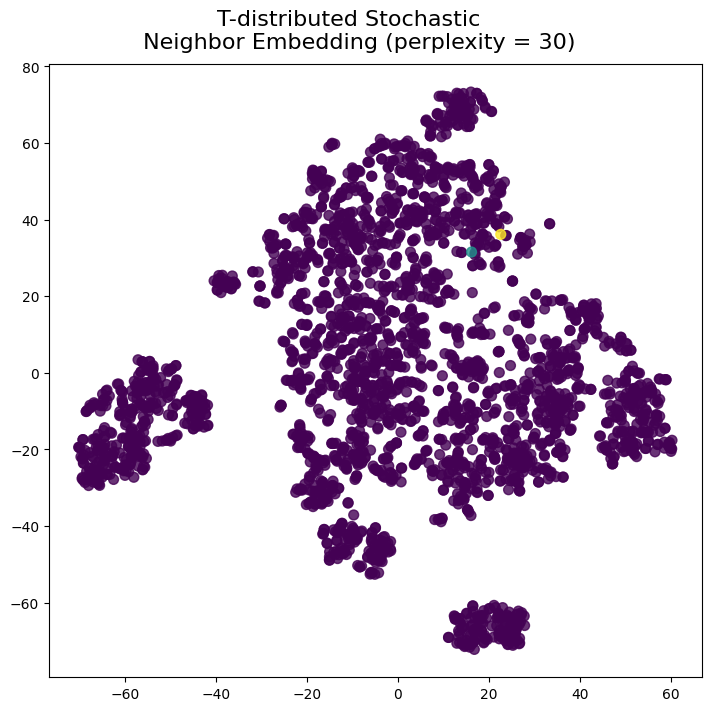

In [234]:
colors = np.array([0] * (sample_all.shape[0] - 2) + [1, 2])
labels = {colors[0]: "others", colors[-1]: "pred", colors[-2]: "GT"}
sizes = {colors[0]: 5, colors[-1]: 10, colors[-2]: 20}

# dump images
image_paths = []
for i in tqdm.tqdm(action_embedding_indices[x]):
    row = action_dataset.iloc[i]
    image_paths.append(f"images/plotly/{row.name}.png")
    if not os.path.exists(image_paths[-1]):
        utils.plot.reaction([molecule_from_smile(row["rsig"])], [molecule_from_smile(row["psig"])], save_file=image_paths[-1])
image_paths = np.array(image_paths)[sample_permute_indices[:-1]]
image_paths= np.concatenate([image_paths, image_paths[-1:]]) # One extra for pred (pred.image = GT.image)

# t-SNE
per = 30
t_sne = manifold.TSNE(
    learning_rate='auto',
    n_components=2,
    perplexity=per,
    init="random",
    n_iter=1000,
    random_state=42,
)

# Create dataframe for easy plotly
S_t_sne = pd.DataFrame(t_sne.fit_transform(sample_all), columns=["x", "y"])
S_t_sne["colors"] = colors
S_t_sne["labels"] = np.vectorize(labels.get)(colors)
S_t_sne["sizes"] = np.vectorize(sizes.get)(colors)
display(S_t_sne)

plot_2d(S_t_sne[["x", "y"]].values, colors, f"T-distributed Stochastic  \n Neighbor Embedding (perplexity = {per})")
plt.show()

In [235]:
from dash import Dash, dcc, html, Input, Output, no_update
from jupyter_dash import JupyterDash
import plotly.express as px

# Plotly figure
# fig = go.Figure(data=[
#     go.Scatter(
#         x=S_t_sne[:, 0][colors==c],
#         y=S_t_sne[:, 1][colors==c],
#         mode="markers",
#         name=f"{labels[c]}",
#         showlegend=True,
#         marker=dict(
#             size=size[c],
#             opacity=0.7,
#         ) 
#     ) for c in np.unique(colors)
# ])
fig = px.scatter(S_t_sne, 
                 x="x", 
                 y="y",
                 color="colors",
                 size="sizes",
                 labels="labels",
                 opacity=0.7
                )

# turn off native plotly.js hover effects - make sure to use
# hoverinfo="none" rather than "skip" which also halts events.
fig.update_traces(hoverinfo="none", hovertemplate=None)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    xaxis=dict(title='X'),
    yaxis=dict(title='Y'),
    plot_bgcolor='rgba(255,255,255,0.1)'
)

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph-basic-2", figure=fig, style={'width': '150vh', 'height': '90vh'}, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph-basic-2", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    # Load image with pillow
    image_path = image_paths[num]
    im = Image.open(image_path)

    # dump it to base64
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    
    img_src = image_paths[num]
    name = labels[colors[num]]
#     form = df_row['FORM']
#     desc = df_row['DESC']
#     if len(desc) > 300:
#         desc = desc[:100] + '...'

    children = [
        html.Div([
            html.Img(src=im_url, style={"width": "200%"}),
            html.H2(f"{name}-{num}", style={"color": "darkblue"}),
#             html.P(f"{form}"),
#             html.P(f"{desc}"),
        ], style={'width': '200px', 'white-space': 'normal'})
    ]

    return True, bbox, children


if __name__ == "__main__":
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

14:45:14   Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/
